In [1]:
!pip install torchattacks


In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import torchattacks

In [ ]:
# from torchattacks import RPGD

In [3]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = './models/lenet_mnist_model.pth' #pretrained_model = "lenet_mnist_model.pth"
use_cuda=True

In [4]:
# from google.colab import drive
# drive.mount('/gdrive')


In [5]:
# simply define a silu function
def srelu(input, slope):
    return slope * F.relu(input)

class SReLU(nn.Module):
    def __init__(self):
        super().__init__() # init the base class

    def forward(self, input, slope):
        return srelu(input, slope) # simply apply already implemented SiLU

In [6]:
# LeNet Model definition
class NetTest(nn.Module):
    def __init__(self, slope):
        super(NetTest, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.slope = slope

    def forward(self, x):
#         s = torch.tensor(.7, requires_grad=False)        
        x = srelu(F.max_pool2d(self.conv1(x), 2), self.slope)
        x = srelu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2), self.slope)    
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = srelu(self.fc1(x), self.slope)
#         x = F.relu(self.fc1(x))        
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        # return F.log_softmax(x, dim=1) 
        # cross entroy does softmax ; nll_loss needs softmax that is why we should first do logsoftmax. # VERY IMPORTATNT !!!!!!!!!!!!!!!!!!!!
        return x 


# # MNIST Test dataset and dataloader declaration
# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
#             transforms.ToTensor(),
#             ])), 
#         batch_size=1, shuffle=True)

# # Define what device we are using
# print("CUDA Available: ",torch.cuda.is_available())
# device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")


# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# # Initialize the network
# model = Net().to(device)

# # Load the pretrained model
# model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# # Set the model in evaluation mode. In this case this is for the Dropout layers
# model.eval()

CUDA Available:  False


In [7]:
test_loader_new = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=100, shuffle=False)

4.3%

100.1%

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


3.5%5%

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


180.4%

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw
Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


In [8]:
import torchvision

epsilons = [0, .05, .1, .15, .2, .25, .3]
slopes   = [.5, 1, 2, 5, 10, 100]
loop = [1,2,3,4,5,6,7]

attackNames = ['FGSM', 'BIM', 'StepLL', 'RFGSM', 'PGD',  'DeepFool']
all_accuracies = torch.empty((len(attackNames), len(slopes), len(epsilons)))


for epIdx, ep in enumerate(epsilons):
    # Run test for each slope
    for slIdx, sl in enumerate(slopes):
        # Initialize the network
        model = NetTest(sl).to(device)
#         model = Holdout(sl).to(device)    
        # Load the pretrained model
        model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))
        # Set the model in evaluation mode. In this case this is for the Dropout layers
        model.eval()


        FGSM = torchattacks.FGSM(model, eps=ep)
        BIM = torchattacks.BIM(model, eps=ep, alpha=1/255, iters=0)
        StepLL = torchattacks.StepLL(model, eps=ep, alpha=1/255, iters=0)
        RFGSM = torchattacks.RFGSM(model, eps=ep, alpha=8/255, iters=5)
        # CW = torchattacks.CW(model, targeted=False, c=1, kappa=0, iters=100, lr=0.01) # large c ignores the norm and cares about misclassification!
        PGD = torchattacks.PGD(model, eps=ep, alpha=2/255, iters=40)
        RPGD = torchattacks.APGD(model, eps=ep, alpha=2/255, iters=40)
        DeepFool = torchattacks.DeepFool(model, iters=loop[epIdx])        
        attacks = [FGSM, BIM, StepLL, RFGSM, PGD, DeepFool]
        # attacks = [DeepFool]

        for attIdx, (attName, attack) in enumerate(zip(attackNames, attacks)):
            print(f'\n Running {attName}, slope={sl}, eps={ep} ... ')

            correct = 0
            total = 0

            for idx, (images, labels) in enumerate(test_loader_new):

                images = images.to(device)
                labels = labels.to(device)

                init_outputs = model(images)
                _, init_pre = torch.max(init_outputs.data, 1)                
                # import pdb; pdb.set_trace()
                new_labels = labels[init_pre == labels]   # correctly predicted samples
                new_images = images[init_pre == labels]

                new_images = attack(new_images, new_labels) #only send the correct predictions
                # plt.imshow(new_images[0].cpu().numpy().squeeze(0))
                # plt.show()
                outputs = model(new_images)

                _, pre = torch.max(outputs.data, 1)

                total += len(labels)
                correct += (pre == new_labels).sum()

        #         if idx == 0:
        #             imshow(torchvision.utils.make_grid(images, nrow=10, normalize=True), '     '.join([str(i.tolist()) for i in pre]))
            acc = (100 * float(correct) / total)
            print('Test Accuracy: %f %%' % acc)
            all_accuracies[attIdx, slIdx, epIdx] = acc
                        
            


 Running FGSM, slope=0.5, eps=0 ... 
Test Accuracy: 90.700000 %

 Running BIM, slope=0.5, eps=0 ... 
Test Accuracy: 90.700000 %

 Running StepLL, slope=0.5, eps=0 ... 
Test Accuracy: 90.700000 %

 Running RFGSM, slope=0.5, eps=0 ... 
Test Accuracy: 90.700000 %

 Running PGD, slope=0.5, eps=0 ... 
Test Accuracy: 90.700000 %

 Running DeepFool, slope=0.5, eps=0 ... 
Test Accuracy: 88.670000 %

 Running FGSM, slope=1, eps=0 ... 
Test Accuracy: 98.100000 %

 Running BIM, slope=1, eps=0 ... 
Test Accuracy: 98.100000 %

 Running StepLL, slope=1, eps=0 ... 
Test Accuracy: 98.100000 %

 Running RFGSM, slope=1, eps=0 ... 
Test Accuracy: 98.100000 %

 Running PGD, slope=1, eps=0 ... 
Test Accuracy: 98.100000 %

 Running DeepFool, slope=1, eps=0 ... 
Test Accuracy: 96.950000 %

 Running FGSM, slope=2, eps=0 ... 
Test Accuracy: 98.210000 %

 Running BIM, slope=2, eps=0 ... 
Test Accuracy: 98.210000 %

 Running StepLL, slope=2, eps=0 ... 
Test Accuracy: 98.210000 %

 Running RFGSM, slope=2, eps=0 

In [ ]:
images[0].max()

tensor(1., device='cuda:0')

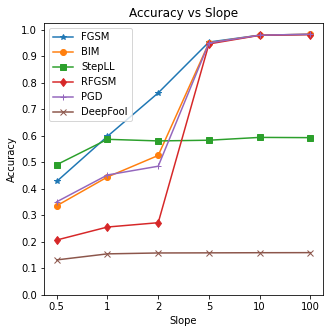

In [12]:
fig = plt.figure(figsize=(5,5))

res = all_accuracies.mean(axis=2)

symbs = ['*-', 'o-',  's-', 'd-', '+-', 'x-', '^-', '<-']
for idx in range(len(res)):
    plt.plot(res[idx,:]/100, symbs[idx])
    
#     plt.plot(epsilons, np.array(all_accuracies).T, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, res.shape[0], step=1), slopes)
plt.title("Accuracy vs Slope")
plt.xlabel("Slope")
plt.ylabel("Accuracy")
plt.legend(attackNames)
plt.show()
fig.savefig(f'./figs/avg-MNIST.png')

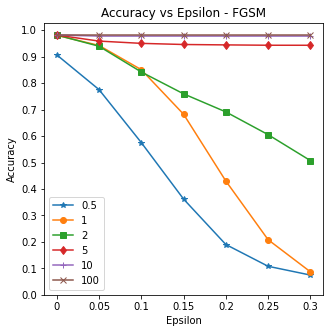

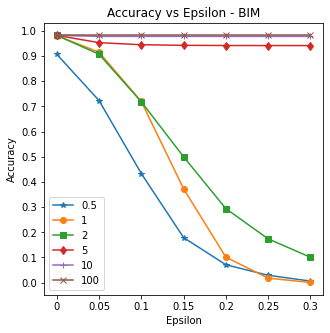

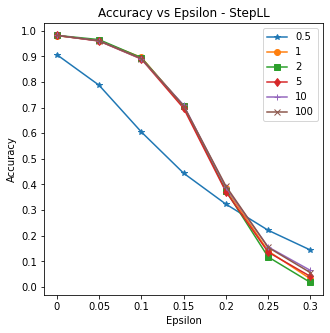

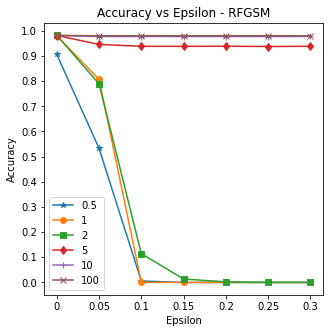

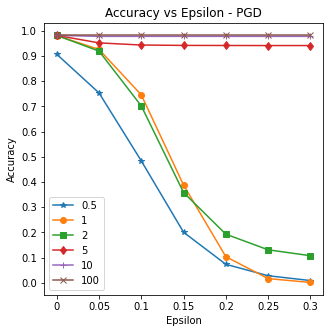

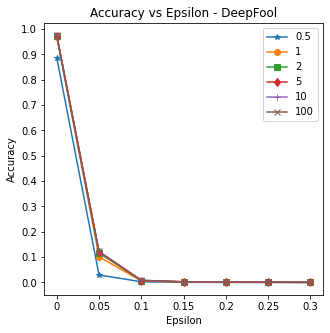

In [15]:


for attIdx, att in enumerate(attackNames):
  fig = plt.figure(figsize=(5,5))
  res = all_accuracies[attIdx]

  symbs = ['*-', 'o-',  's-', 'd-', '+-', 'x-', '^-', '<-']
  for idx in range(len(res)):
      plt.plot(res[idx,:]/100, symbs[idx])
      
  #     plt.plot(epsilons, np.array(all_accuracies).T, "*-")
  plt.yticks(np.arange(0, 1.1, step=0.1))
  plt.xticks(np.arange(0, len(epsilons), step=1), epsilons)
  plt.title(f"Accuracy vs Epsilon - {att}")
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.legend(slopes)
  plt.show()
  fig.savefig(f'./figs/avg-MNIST-{att}.png')

In [ ]:
tmp = all_accuracies
torch.save(all_accuracies,'/gdrive/My Drive/Tmp/accs_CIFAR10.npy')

In [ ]:
all_accuracies.shape

torch.Size([6, 6, 7])

In [9]:
torch.save(all_accuracies,'./Tmp/accs_MNIST.npy')
# all_accuracies = torch.load('/gdrive/My Drive/Tmp/accs_MNIST.npy')

FileNotFoundError: [Errno 2] No such file or directory: './Tmp/accs_MNIST.npy'

# Analysis of Activation functions

In [ ]:



# LeNet Model definition
class NewNetTest(nn.Module):
    def __init__(self, act):
        super(NewNetTest, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.act = act

    def forward(self, x):
        x = self.act(F.max_pool2d(self.conv1(x), 2))
        x = self.act(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))    
        x = x.view(-1, 320)
        x = self.act(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)



In [ ]:

epsilons = [0, .05, .1, .15, .2, .25, .3]
activations = [nn.Sigmoid(), nn.Tanh(), nn.Softsign(), nn.Softplus(), nn.CELU(), nn.ReLU()]
act_accs = torch.zeros(len(activations), len(epsilons))


for actIdx, act in enumerate(activations):
  for epIdx, ep in enumerate(epsilons):
      # Initialize the network
      model = NewNetTest(act).to(device)
      model.load_state_dict(torch.load(pretrained_model, map_location='cuda'))
      # Set the model in evaluation mode. In this case this is for the Dropout layers
      model.eval()


      FGSM = torchattacks.FGSM(model, eps=ep)

      correct = 0
      total = 0

      for idx, (images, labels) in enumerate(test_loader_new):

          # attack only those that have been correctly classified
          images = images.to(device)
          labels = labels.to(device)

          init_outputs = model(images)
          _, init_pre = torch.max(init_outputs.data, 1)                
          # import pdb; pdb.set_trace()
          new_labels = labels[init_pre == labels]
          new_images = images[init_pre == labels]

          new_images = FGSM(new_images, new_labels)
          outputs = model(new_images)

          _, pre = torch.max(outputs.data, 1)

          total += len(labels)
          correct += (pre == new_labels).sum()

  #         if idx == 0:
  #             imshow(torchvision.utils.make_grid(images, nrow=10, normalize=True), '     '.join([str(i.tolist()) for i in pre]))
      acc = (100 * float(correct) / total)
      print('Test Accuracy: %f %%' % acc)
      act_accs[actIdx, epIdx] = acc

Test Accuracy: 19.360000 %
Test Accuracy: 17.790000 %
Test Accuracy: 14.830000 %
Test Accuracy: 11.200000 %
Test Accuracy: 8.080000 %
Test Accuracy: 5.940000 %
Test Accuracy: 3.590000 %
Test Accuracy: 79.680000 %
Test Accuracy: 50.130000 %
Test Accuracy: 27.320000 %
Test Accuracy: 14.320000 %
Test Accuracy: 7.350000 %
Test Accuracy: 3.620000 %
Test Accuracy: 1.600000 %
Test Accuracy: 69.880000 %
Test Accuracy: 41.480000 %
Test Accuracy: 22.670000 %
Test Accuracy: 11.970000 %
Test Accuracy: 5.850000 %
Test Accuracy: 2.380000 %
Test Accuracy: 0.820000 %
Test Accuracy: 60.990000 %
Test Accuracy: 44.970000 %
Test Accuracy: 35.200000 %
Test Accuracy: 24.420000 %
Test Accuracy: 14.210000 %
Test Accuracy: 6.910000 %
Test Accuracy: 3.140000 %
Test Accuracy: 97.130000 %
Test Accuracy: 90.260000 %
Test Accuracy: 73.400000 %
Test Accuracy: 44.120000 %
Test Accuracy: 18.500000 %
Test Accuracy: 5.580000 %
Test Accuracy: 1.290000 %
Test Accuracy: 98.100000 %
Test Accuracy: 94.250000 %
Test Accuracy:

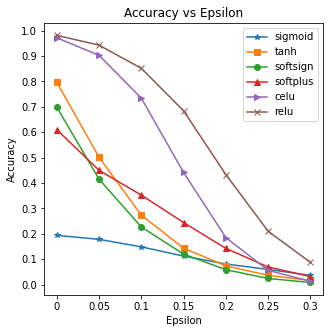

In [ ]:
fig=plt.figure(figsize=(5,5))
symbs = ['*-', 's-', 'o-', '^-', '>-', 'x-', '<-']
for idx, acc in enumerate(act_accs):
    plt.plot(acc/100, symbs[idx])
    
#     plt.plot(epsilons, np.array(all_accuracies).T, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, len(epsilons)), epsilons)
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend(['sigmoid', 'tanh', 'softsign', 'softplus', 'celu', 'relu'])
plt.show()
fig.savefig(f'/gdrive/My Drive/Tmp/Activations-MNIST.png')